In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import MinMaxScaler

# File paths
csv_path = "nutritional_values.csv"
images_folder = "Dates/"

# Load the CSV
df = pd.read_csv(csv_path)

# Ensure required columns are present
required_columns = ['image_id', 'calories', 'proteins', 'total_fat', 'glucose', 'cholesterol', 'water', 'Energy (Kcal)']
if not all(col in df.columns for col in required_columns):
    raise ValueError(f"CSV must contain columns: {', '.join(required_columns)}")

# Preprocessing: Load images and normalize nutritional values
X = []
y = []
missing_images = 0

for _, row in df.iterrows():
    image_path = os.path.join(images_folder, row['image_id'] + '.jpg')
    if os.path.exists(image_path):
        # Load image, resize to 128x128, and normalize pixel values
        image = load_img(image_path, target_size=(128, 128))
        image = img_to_array(image) / 255.0
        X.append(image)

        # Extract nutritional values
        y.append(row[['calories', 'proteins', 'total_fat', 'glucose', 'cholesterol', 'water', 'Energy (Kcal)']].values)
    else:
        missing_images += 1

print(f"Missing images: {missing_images}")
X = np.array(X)
y = np.array(y)

# Normalize the target values using MinMaxScaler
scaler = MinMaxScaler()
y = scaler.fit_transform(y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

Missing images: 0
Training samples: 2165, Testing samples: 542


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='linear')  # 7 outputs for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32
)

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - loss: 0.3225 - mae: 0.3971 - val_loss: 0.1082 - val_mae: 0.2588
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - loss: 0.1207 - mae: 0.2802 - val_loss: 0.1108 - val_mae: 0.2625
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - loss: 0.1164 - mae: 0.2724 - val_loss: 0.1053 - val_mae: 0.2559
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - loss: 0.1145 - mae: 0.2697 - val_loss: 0.1065 - val_mae: 0.2574
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - loss: 0.1093 - mae: 0.2640 - val_loss: 0.1083 - val_mae: 0.2609
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - loss: 0.1090 - mae: 0.2631 - val_loss: 0.1080 - val_mae: 0.2582
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - loss: 0.1083 - mae: 0.2613 - val_loss: 0.1065 - val_mae: 0.2563
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - loss: 0.1064 - mae: 0.2588 - val_loss: 0.1065 - val_mae: 0.2580
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - loss: 0.10

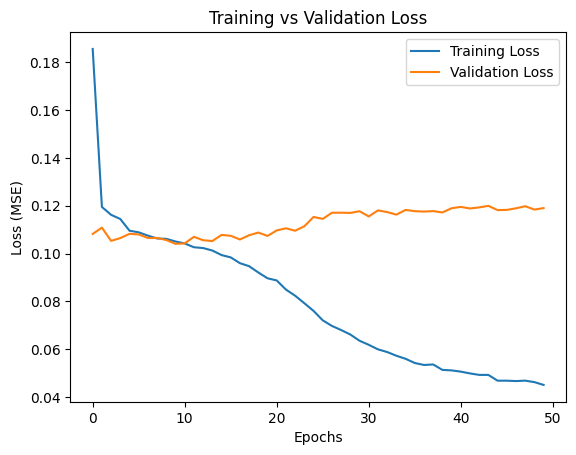

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.1199 - mae: 0.2665
Test Loss: 0.11901361495256424, Test MAE: 0.2645500898361206


In [3]:
from matplotlib import pyplot as plt

# Plot training vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

# Evaluate the model on test data
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


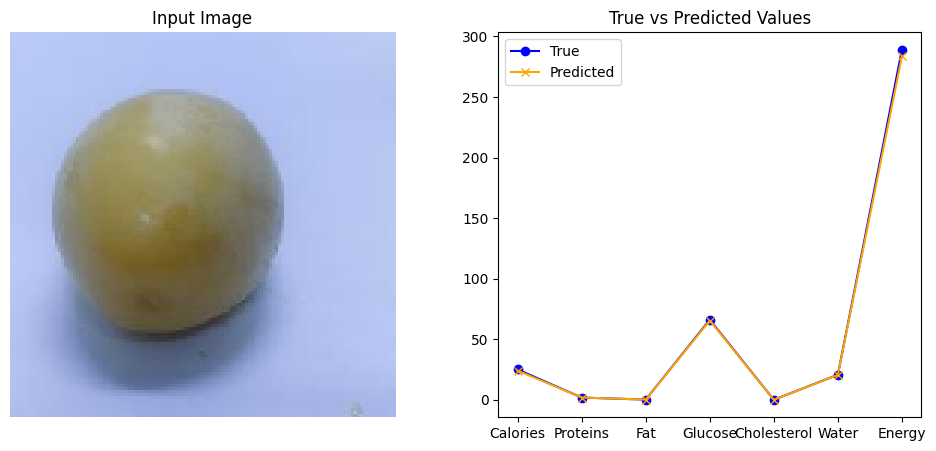

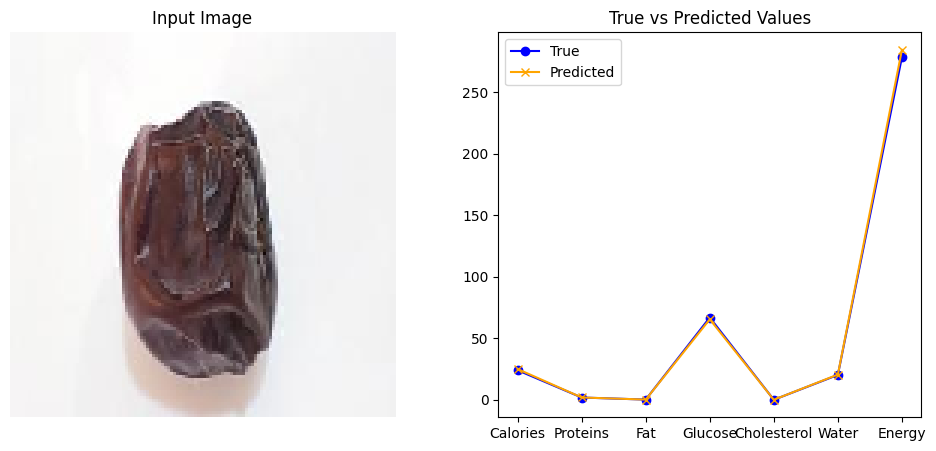

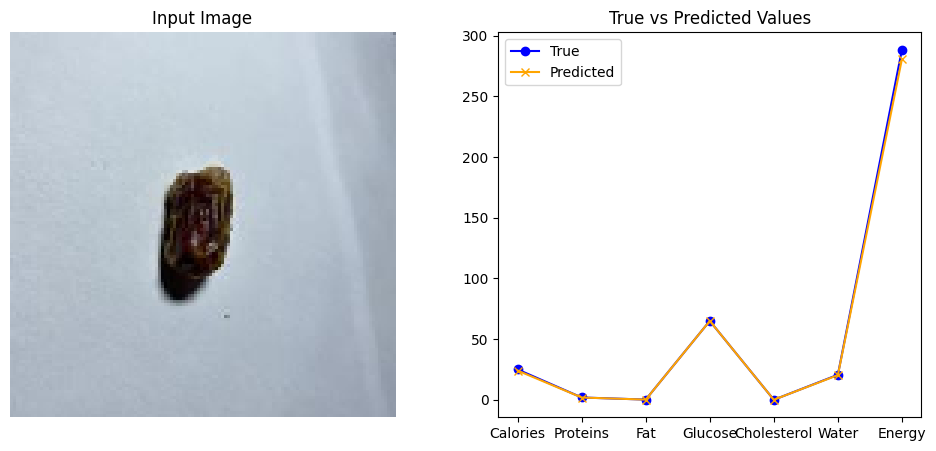

In [5]:
# Predict on test data
predictions = model.predict(X_test)

# Reverse scaling for true values
y_test_original = scaler.inverse_transform(y_test)
predictions_original = scaler.inverse_transform(predictions)

# Visualize predictions for the first few test samples
def visualize_predictions(X, y_true, y_pred, num_samples=3):
    for i in range(num_samples):
        plt.figure(figsize=(12, 5))

        # Display the image
        plt.subplot(1, 2, 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title("Input Image")

       # Display true vs predicted values
        plt.subplot(1, 2, 2)
        indices = range(len(y_true[i]))
        plt.plot(indices, y_true[i], label='True', color='blue', marker='o')
        plt.plot(indices, y_pred[i], label='Predicted', color='orange', marker='x')
        plt.xticks(indices, ['Calories', 'Proteins', 'Fat', 'Glucose', 'Cholesterol', 'Water', 'Energy'])
        plt.legend()
        plt.title("True vs Predicted Values")
        plt.show()

visualize_predictions(X_test, y_test_original, predictions_original)

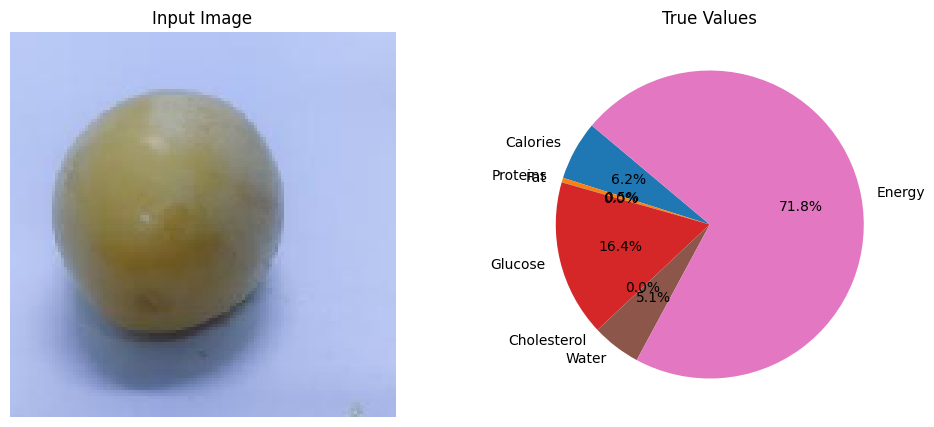

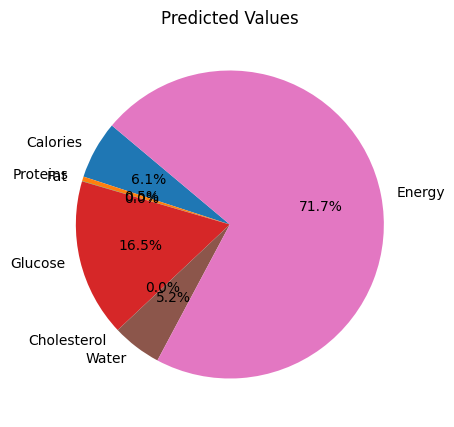

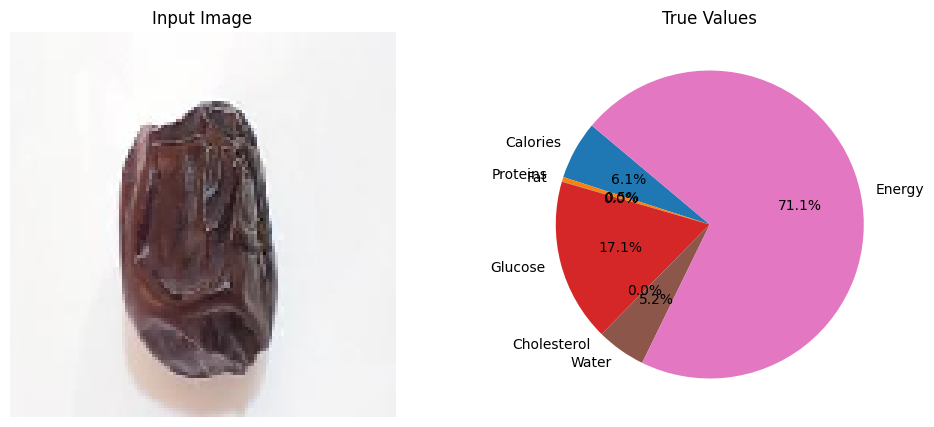

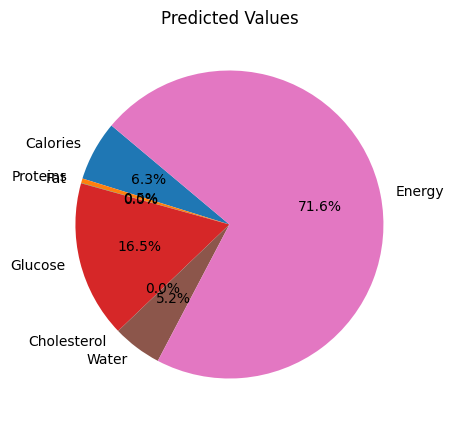

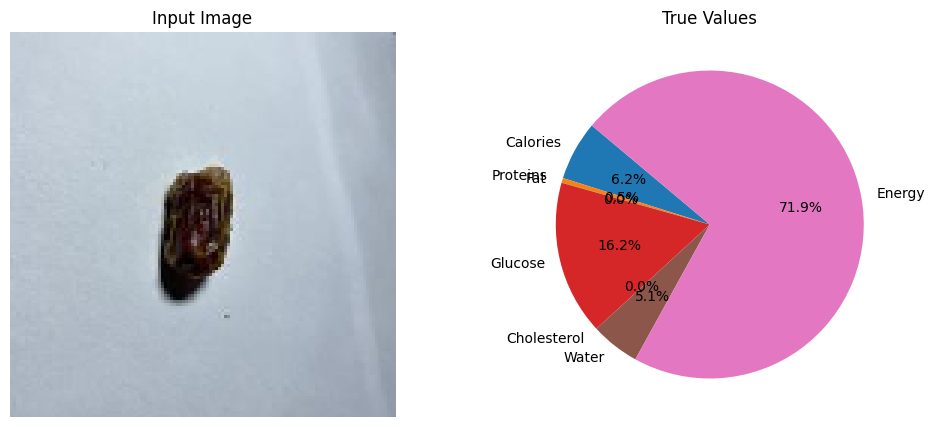

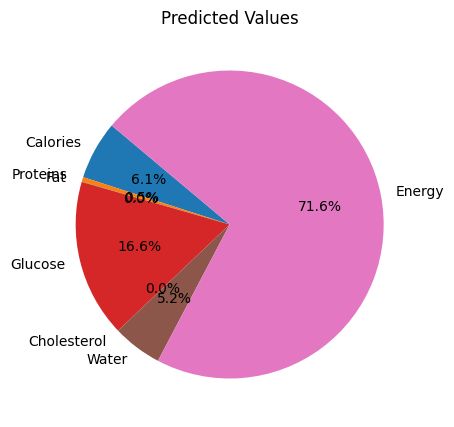

In [7]:
from matplotlib import pyplot as plt
import numpy as np

# Display true vs predicted values as pie charts
def visualize_predictions(X, y_true, y_pred, num_samples=3):
    for i in range(num_samples):
        plt.figure(figsize=(12, 5))

        # Display the image
        plt.subplot(1, 2, 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title("Input Image")

        # Ensure non-negative values for true values
        y_true_non_negative = np.maximum(y_true[i], 0)

        # Display true values as a pie chart
        plt.subplot(1, 2, 2)
        plt.pie(y_true_non_negative, labels=['Calories', 'Proteins', 'Fat', 'Glucose', 'Cholesterol', 'Water', 'Energy'], autopct='%1.1f%%', startangle=140)
        plt.title("True Values")

        # Ensure non-negative values for predicted values
        y_pred_non_negative = np.maximum(y_pred[i], 0)

        # Display predicted values as a pie chart
        plt.figure(figsize=(12, 5))
        plt.pie(y_pred_non_negative, labels=['Calories', 'Proteins', 'Fat', 'Glucose', 'Cholesterol', 'Water', 'Energy'], autopct='%1.1f%%', startangle=140)
        plt.title("Predicted Values")
        plt.show()

visualize_predictions(X_test, y_test_original, predictions_original)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted Nutritional Values:
calories: 23.94
proteins: 1.86
total_fat: 0.15
glucose: 65.27
cholesterol: -0.00
water: 20.43
Energy (Kcal): 281.68


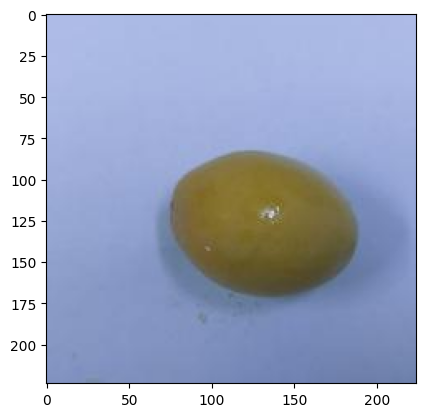

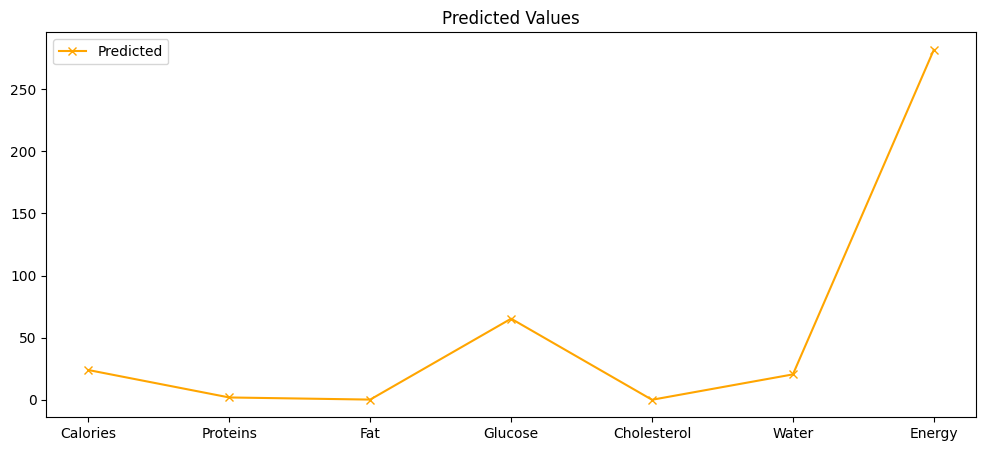

In [8]:

image_path = 'Dates/Barhi_004.jpg'

# Load and preprocess the image
image = load_img(image_path, target_size=(128, 128))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)

# Predict the nutritional values
prediction = model.predict(image)
prediction_original = scaler.inverse_transform(prediction)

# Display the predicted values
print("Predicted Nutritional Values:")
for i, value in enumerate(prediction_original[0]):
    print(f"{required_columns[i+1]}: {value:.2f}")

# Display the image
plt.imshow(load_img(image_path))
plt.axis()
plt.show()


# visualize True vs Predicted Values as plot
plt.figure(figsize=(12, 5))
indices = range(len(prediction_original[0]))
plt.plot(indices, prediction_original[0], label='Predicted', color='orange', marker='x')
plt.xticks(indices, ['Calories', 'Proteins', 'Fat', 'Glucose', 'Cholesterol', 'Water', 'Energy'])
plt.legend()
plt.title("Predicted Values")
plt.show()


In [9]:
# Save the model
model.save('001_nutritional_value_predictor.h5')

In [1]:
import numpy as np

# Define accuracy metric for regression
def regression_accuracy(y_true, y_pred, tolerance=0.1):
    relative_error = np.abs((y_true - y_pred) / y_true)  # Relative error
    accurate_predictions = np.sum(relative_error <= tolerance)  # Predictions within tolerance
    accuracy = (accurate_predictions / len(y_true)) * 100  # Percentage accuracy
    return accuracy

train_accuracy_lr = regression_accuracy(y_train, model.predict(X_train))
test_accuracy_lr = regression_accuracy(y_test, model.predict(X_test))
print(f"Linear Regression - Train Accuracy: {train_accuracy_lr:.2f}%, Test Accuracy: {test_accuracy_lr:.2f}%")

NameError: name 'y_train' is not defined

In [3]:
import pandas as pd

# Load your dataset
data = pd.read_csv('nutritional_values.csv')

# Check the first few rows to identify the columns
print(data.head())

# Assuming the target column is named 'calories' (you can replace 'calories' with the actual column name)
min_value = data['calories'].min()  # Replace 'calories' with your target column name
max_value = data['calories'].max()  # Replace 'calories' with your target column name

print(f"Min value: {min_value}, Max value: {max_value}")

   image_id  type                                           taxonomy  \
0  Ajwa_001  Ajwa  Kingdom - Plantae, Order - Arecales, Family - ...   
1  Ajwa_002  Ajwa  Kingdom - Plantae, Order - Arecales, Family - ...   
2  Ajwa_003  Ajwa  Kingdom - Plantae, Order - Arecales, Family - ...   
3  Ajwa_004  Ajwa  Kingdom - Plantae, Order - Arecales, Family - ...   
4  Ajwa_005  Ajwa  Kingdom - Plantae, Order - Arecales, Family - ...   

                                    vernacular_names  calories  carbohydrate  \
0  Arabic-Nakhleh, English-Date friut, French-Dat...        23         74.97   
1  Arabic-Nakhleh, English-Date friut, French-Dat...        25         78.39   
2  Arabic-Nakhleh, English-Date friut, French-Dat...        24         75.41   
3  Arabic-Nakhleh, English-Date friut, French-Dat...        23         75.67   
4  Arabic-Nakhleh, English-Date friut, French-Dat...        25         77.63   

   proteins  total_fat  cholesterol  dietary_fiber  ...  Magnesium (mg)  \
0      1.81